In [50]:
#Importing the neccessary libraries
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
import nltk
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import re
import string
import pickle
import nltk
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,SpatialDropout1D,LSTM,Dense
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [4]:
import json

In [7]:
with open('intents.json') as f:
    data=json.load(f)

In [12]:
x=[]
y=[]
for intents in data['intents']:
    for pattern in intents['patterns']:
        x.append(pattern)
        y.append(intents['tag'])

In [37]:
def process_text(text):
    text=text.lower()
    text = re.sub(r'[^\w\s\d]', '', text)
    lem = WordNetLemmatizer()
    text= ' '.join(lem.lemmatize(term) for term in str(text).split())    
    return text

In [41]:
for i in range(len(x)):
    x[i]=process_text(x[i])

In [77]:
#Getting the maximum number of words in any row
maximum = 0
for i in x:
    words=[]
    for word in i.split(' '):
        words.append(word)
    no_of_words = len(words)
#     print(no_of_words)
    if no_of_words>maximum:
        maximum = no_of_words
    else:
        continue

In [78]:
maximum

6

In [55]:
# Total number of tags
no_of_tags=len(np.unique(y))

In [36]:
#Label Encode the classes
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(y)
print(y)

[2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 0 0 0 0 0 0 4 4 4 5 5 5 5 5 3 3 3 3 3 6 6 6
 6]


In [79]:
#This is the number of vocabulary we can have.
MAX_NB_WORDS = 1000
# Max number of words in the whole dataset in any row
MAX_SEQUENCE_LENGTH = maximum
# This is fixed.
EMBEDDING_DIM = 100
# Lets intialise the tokenizer with filters on punctuation and lower the case of the input
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
# Fit on the text of the data
tokenizer.fit_on_texts(x)
#Lets check for the total unique token in the corpus
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 63 unique tokens.


In [80]:
X = tokenizer.texts_to_sequences(x)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
X= np.array(X,dtype=np.float32)

In [83]:
# Convert it into dummy variable of the output class
Y = pd.get_dummies(y)
print('Shape of label tensor:', Y.shape)
#Splitting it into train and test set.. HOLDOUT sets.
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
#Lets check the shape if everything is fine
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

Shape of label tensor: (38, 7)
(34, 6) (34, 7)
(4, 6) (4, 7)


In [84]:
X_train=tf.cast(X_train,tf.float32)
Y_train=tf.cast(Y_train,tf.float32)
X_test=tf.cast(X_test,tf.float32)
Y_test=tf.cast(Y_test,tf.float32)

In [85]:
# Lets define the architecture
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(100))
model.add(Dense(no_of_tags, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 20
batch_size = 4
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_data=(X_test,Y_test),callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/20
9/9 [==============================] - 0s 35ms/step - loss: 1.9422 - accuracy: 0.2059 - val_loss: 1.9010 - val_accuracy: 0.5000
Epoch 2/20
9/9 [==============================] - 0s 8ms/step - loss: 1.8913 - accuracy: 0.4118 - val_loss: 1.8726 - val_accuracy: 0.2500
Epoch 3/20
9/9 [==============================] - 0s 8ms/step - loss: 1.8334 - accuracy: 0.3529 - val_loss: 1.7891 - val_accuracy: 0.2500
Epoch 4/20
9/9 [==============================] - 0s 8ms/step - loss: 1.7323 - accuracy: 0.3529 - val_loss: 1.6704 - val_accuracy: 0.2500
Epoch 5/20
9/9 [==============================] - 0s 8ms/step - loss: 1.6317 - accuracy: 0.3529 - val_loss: 1.6119 - val_accuracy: 0.5000
Epoch 6/20
9/9 [==============================] - 0s 8ms/step - loss: 1.5509 - accuracy: 0.4706 - val_loss: 1.6553 - val_accuracy: 0.5000
Epoch 7/20
9/9 [==============================] - 0s 8ms/step - loss: 1.4262 - accuracy: 0.5294 - val_loss: 1.5600 - val_accuracy: 0.5000
Epoch 8/20
9/9 [=================

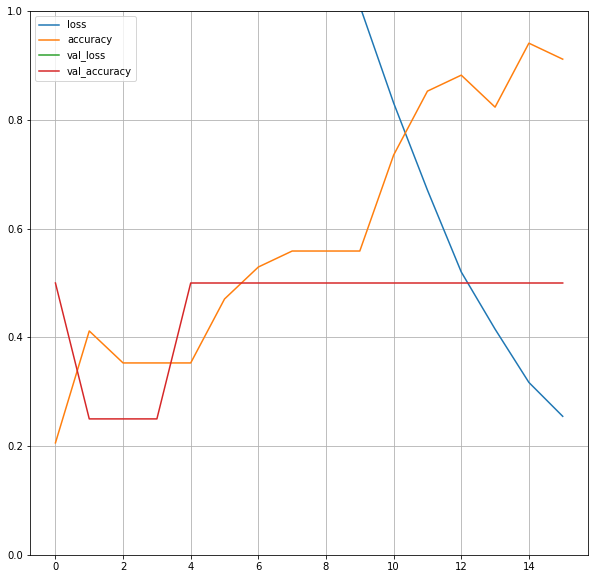

In [86]:
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(10,10))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()